In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import numpy as np


def transform_to_utm(gdf):
  centroid = gdf.geometry.unary_union.centroid
  utm_zone = int((centroid.x + 180) / 6) + 1
  utm_crs = f"EPSG:326{utm_zone:02d}" if centroid.y >= 0 else f"EPSG:327{utm_zone:02d}"

  return gdf.to_crs(utm_crs)

def trasform_to_gdf(json):
  df = pd.read_json(json)
  df['latitude'] = df['coordinates'].apply(lambda x: x['latitude'])
  df['longitude'] = df['coordinates'].apply(lambda x: x['longitude'])

  # Создаем геометрию
  geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
  gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

  gdf = gdf.drop(['coordinates'], axis=1)
  return gdf

cafe_gdf = trasform_to_gdf("drive/MyDrive/data/basman_cafes.json")
cafes_utm = transform_to_utm(cafe_gdf)

edu_gdf = trasform_to_gdf("drive/MyDrive/data/basman_complete_education.json")
edu_utm = transform_to_utm(edu_gdf)

med_gdf = trasform_to_gdf("drive/MyDrive/data/basman_medical.json")
med_utm = transform_to_utm(med_gdf)

# df = pd.read_json("data/basmannyy_transport_and_offices.json")
# stops_gdf
import json
with open('drive/MyDrive/data/basmannyy_transport_and_offices.json', 'r', encoding = 'utf-8') as f:
    transp_offices = json.load(f)
all_objects = []

for key, value in transp_offices.items():
    if len(value) == 0:
        continue
    df = pd.json_normalize(value)
    df["type"] = key
    all_objects.append(df)

combined_df = pd.concat(all_objects, ignore_index=True)
combined_df = combined_df[['id', 'type', 'name', 'lat', 'lon']]

combined_gdf = gpd.GeoDataFrame(
    combined_df,
    geometry=gpd.points_from_xy(combined_df['lon'], combined_df['lat']),
    crs='EPSG:4326'
)

stops_utm = transform_to_utm(combined_gdf)

all_objects_utm = gpd.GeoDataFrame(
    pd.concat([cafes_utm, edu_utm, stops_utm, med_utm], ignore_index=True),
    crs=cafes_utm.crs
)

print(f"✅ Создан all_objects_utm с {all_objects_utm.head} объектами")

radii=[500, 1000, 2000, 5000]
"""Анализ объектов в разных радиусах"""
results = []

for cafe_idx, cafe in cafes_utm.iterrows():
    for radius in radii:
        # Создаем буфер для текущего радиуса
        buffer = cafe.geometry.buffer(radius)

        # Находим объекты внутри буфера по типам
        nearby_objects = all_objects_utm[all_objects_utm.geometry.within(buffer)]

        # Считаем по типам
        counts = nearby_objects['type'].value_counts().to_dict()

        results.append({
            'cafe_name': cafe['name'],
            'radius_m': radius,
            'radius_km': radius / 1000,
            'cafe_lat': cafe['latitude'],
            'cafe_lon': cafe['longitude'],
            'universities_count': counts.get('university', 0),
            'clinic_count': counts.get('clinic', 0),
            'stops_count': counts.get('metro_stations', 0) + counts.get('bus_stops', 0),
            'schools_count': counts.get('school', 0),
            'cafes_count': counts.get('cafe', 0) - 1,  # исключаем само кафе
            'total_objects': len(nearby_objects) - 1   # исключаем само кафе
        })

radius_analysis = pd.DataFrame(results)
print(radius_analysis)

/tmp/ipython-input-1413640941.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid
/tmp/ipython-input-1413640941.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid
/tmp/ipython-input-1413640941.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid
/tmp/ipython-input-1413640941.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid


✅ Создан all_objects_utm с <bound method NDFrame.head of              name        type osm_type                      address  \
0             Com        cafe     node                                
1     Шоколадница        cafe     node                                
2       Кофе Хауз        cafe     node                                
3       Алтаргана        cafe     node                                
4          Буржуй        cafe     node  Нижняя Красносельская улица   
...           ...         ...      ...                          ...   
1654     Гемотест  laboratory     node                                
1655        ДНКОМ  laboratory     node                                
1656     Labquest  laboratory     node                                
1657          CMD  laboratory     node                                
1658      Пикассо  laboratory     node                                

          cuisine rating             website   latitude  longitude  \
0      vietnamese   

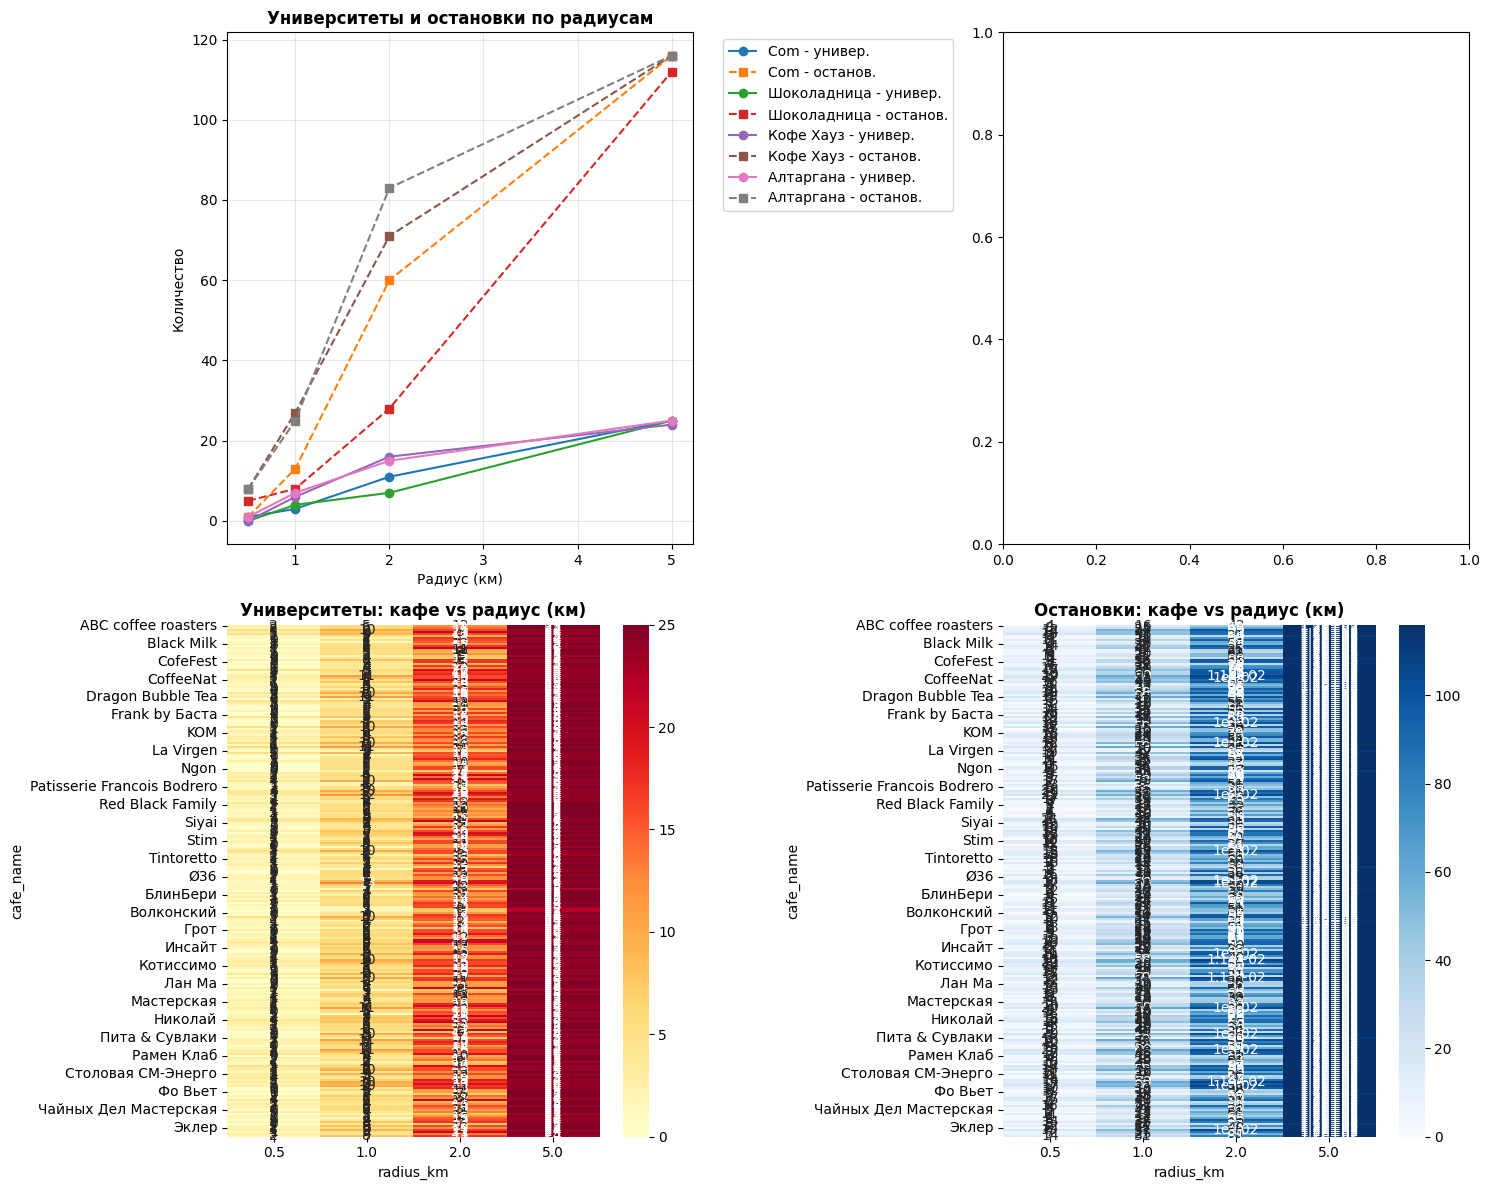

/tmp/ipython-input-1104117649.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipython-input-1104117649.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipython-input-1104117649.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipython-input-1104117649.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


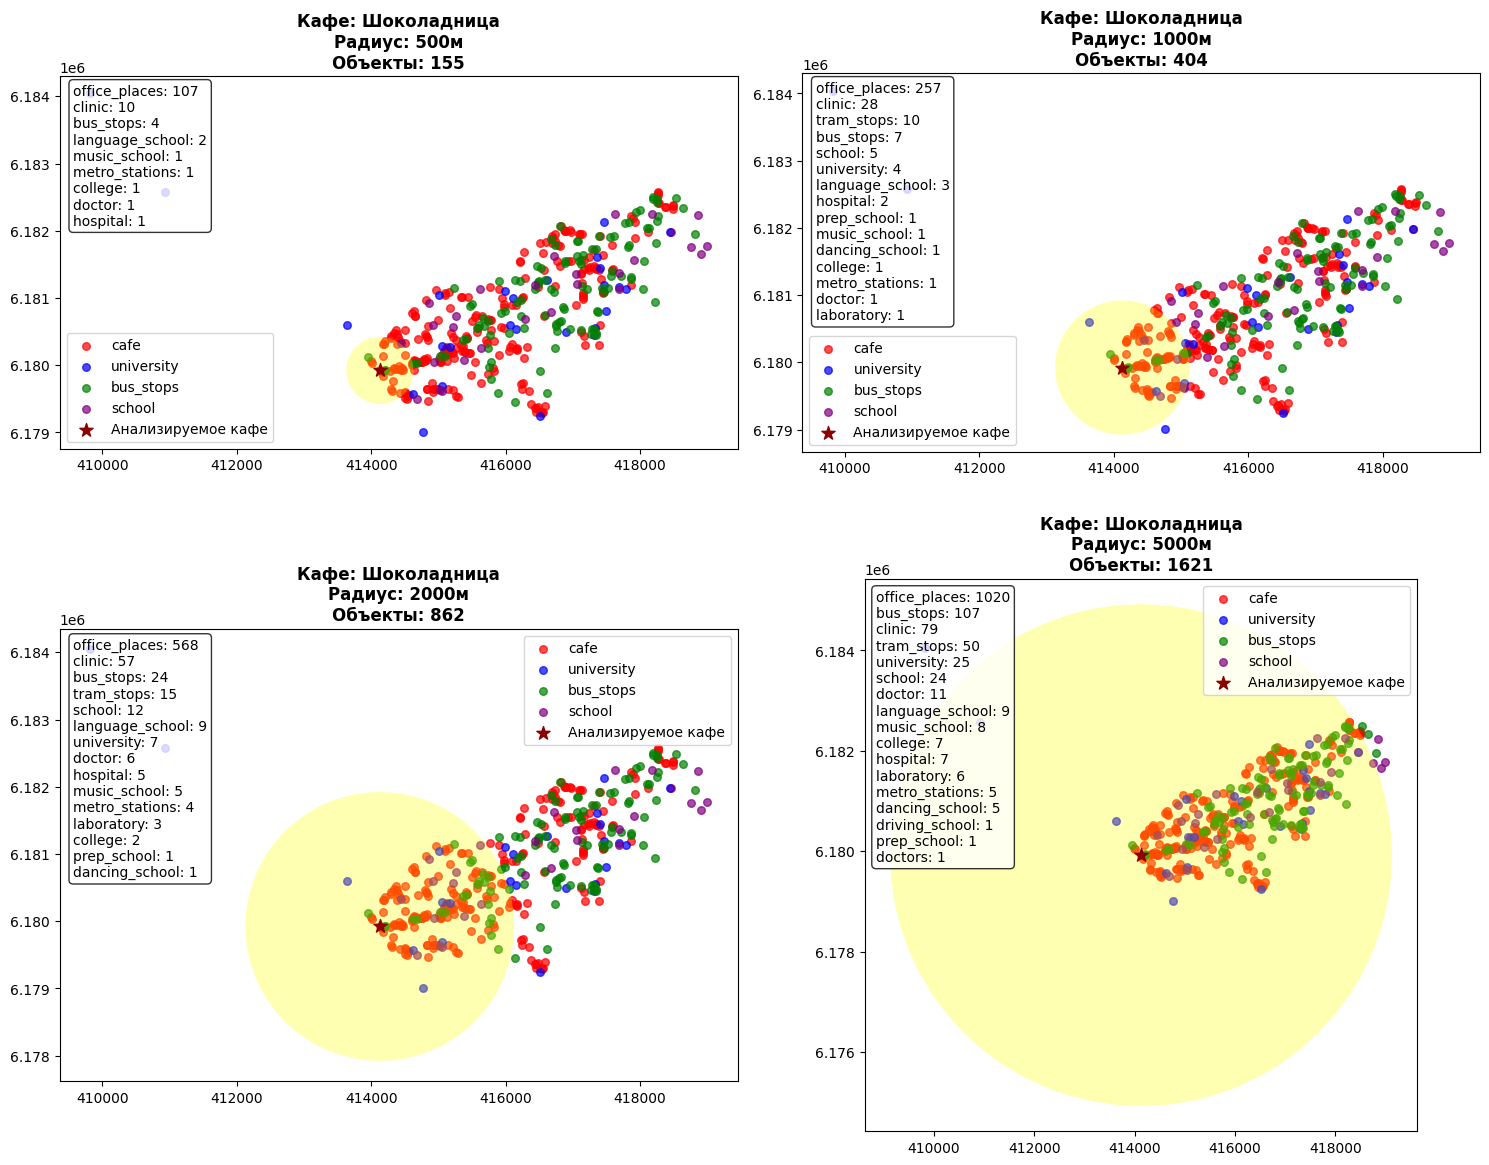

In [17]:

"""Создание визуализаций для разных радиусов"""

# 1. График изменения количества объектов с ростом радиуса
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Для каждого кафе - линии по разным типам объектов
cafe_names = radius_analysis['cafe_name'].unique()

# График 1: Университеты и остановки
for cafe in cafe_names[:4]:  # первые 4 кафе для читаемости
    cafe_data = radius_analysis[radius_analysis['cafe_name'] == cafe]
    axes[0, 0].plot(cafe_data['radius_km'], cafe_data['universities_count'],
                    marker='o', label=f'{cafe} - универ.')
    axes[0, 0].plot(cafe_data['radius_km'], cafe_data['stops_count'],
                    marker='s', linestyle='--', label=f'{cafe} - останов.')

axes[0, 0].set_title('Университеты и остановки по радиусам', fontweight='bold')
axes[0, 0].set_xlabel('Радиус (км)')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# График 3: Heatmap по радиусам и кафе (университеты)
heatmap_data = radius_analysis.pivot_table(
    index='cafe_name', columns='radius_km', values='universities_count'
)
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Университеты: кафе vs радиус (км)', fontweight='bold')

# График 4: Heatmap по радиусам и кафе (остановки)
heatmap_data_stops = radius_analysis.pivot_table(
    index='cafe_name', columns='radius_km', values='stops_count'
)
sns.heatmap(heatmap_data_stops, annot=True, cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Остановки: кафе vs радиус (км)', fontweight='bold')

plt.tight_layout()
plt.savefig('radius_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Карты с разными радиусами для выбранного кафе
# create_radius_maps()

# fig


"""Создание карт с разными радиусами для визуализации"""
# Выбираем одно кафе для демонстрации
demo_cafe = cafes_utm.iloc[1]
radii = [500, 1000, 2000, 5000]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, radius in enumerate(radii):
    ax = axes[idx]

    # Отображаем все объекты
    types_colors = {
        'cafe': 'red', 'university': 'blue',
        'bus_stops': 'green', 'school': 'purple'
    }

    for obj_type, color in types_colors.items():
        type_data = all_objects_utm[all_objects_utm['type'] == obj_type]
        type_data.plot(ax=ax, color=color, markersize=30, label=obj_type, alpha=0.7)

    # Отображаем буферную зону
    buffer = demo_cafe.geometry.buffer(radius)
    gpd.GeoSeries([buffer]).plot(ax=ax, color='yellow', alpha=0.3,
                                label=f'Радиус {radius}м')

    # Выделяем анализируемое кафе
    cafes_utm[cafes_utm['name'] == demo_cafe['name']].plot(
        ax=ax, color='darkred', markersize=100, marker='*',
        label='Анализируемое кафе'
    )

    # Подсчет объектов в радиусе
    nearby_objects = all_objects_utm[
        all_objects_utm.geometry.within(buffer)
    ]
    counts = nearby_objects['type'].value_counts()

    ax.set_title(
        f"Кафе: {demo_cafe['name']}\n"
        f"Радиус: {radius}м\n"
        f"Объекты: {len(nearby_objects)-1}",
        fontweight='bold'
    )
    ax.legend()

    # Добавляем статистику на карту
    stats_text = "\n".join([f"{k}: {v}" for k, v in counts.items() if k != 'cafe'])
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('radius_maps_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# По примеру с шоколадницей видно, что около нее в радиусе 500 метров 2 остановки автобуса
# Гипотеза 1
# Около каждого кафе есть остановки общественного транспорта и их больше 1
# Посчитаем сколько кафе соответствует этому критерию
# Фильтруем данные только для радиуса 500м
radius_500 = radius_analysis[radius_analysis['radius_m'] == 500]
# Основная статистика по остановкам в радиусе 500м
print("Статистика по количеству остановок в радиусе 500м:")
print(radius_500['stops_count'].describe())

# Проверяем гипотезу
total_cafes = len(radius_500)
cafes_with_2_or_more_stops = len(radius_500[radius_500['stops_count'] >= 2])
percentage = (cafes_with_2_or_more_stops / total_cafes) * 100

print(f"\n--- Результаты проверки гипотезы ---")
print(f"Всего кафе: {total_cafes}")
print(f"Кафе с ≥2 остановками: {cafes_with_2_or_more_stops}")
print(f"Процент выполнения гипотезы: {percentage:.2f}%")

Статистика по количеству остановок в радиусе 500м:
count    257.000000
mean       8.766537
std        5.743880
min        0.000000
25%        4.000000
50%        8.000000
75%       14.000000
max       21.000000
Name: stops_count, dtype: float64

--- Результаты проверки гипотезы ---
Всего кафе: 257
Кафе с ≥2 остановками: 238
Процент выполнения гипотезы: 92.61%


Считаю, что можно сказать, что гипотеза выполняется. Практически у каждого кафе (93%) есть рядом 2 остановки

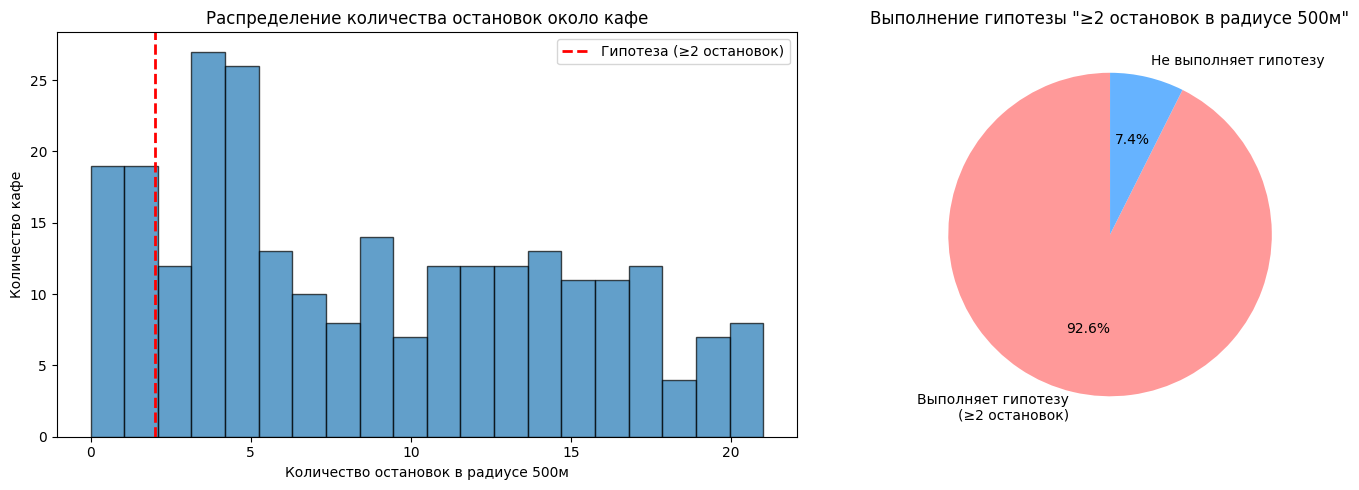

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма распределения количества остановок
ax1.hist(radius_500['stops_count'], bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(x=2, color='red', linestyle='--', linewidth=2, label='Гипотеза (≥2 остановок)')
ax1.set_xlabel('Количество остановок в радиусе 500м')
ax1.set_ylabel('Количество кафе')
ax1.set_title('Распределение количества остановок около кафе')
ax1.legend()

# Круговая диаграмма выполнения гипотезы
labels = ['Выполняет гипотезу\n(≥2 остановок)', 'Не выполняет гипотезу']
sizes = [cafes_with_2_or_more_stops, total_cafes - cafes_with_2_or_more_stops]
colors = ['#ff9999', '#66b3ff']
ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Выполнение гипотезы "≥2 остановок в радиусе 500м"')

plt.tight_layout()
plt.show()

In [20]:
# Всё таки не с каждым кафе рядом есть остановки общ. транспорта.
# Гипотеза 2
# Рядом с кафе, где нет остановок, есть либо вуз, либо школа, либо клиника

# Анализ кафе, которые НЕ удовлетворяют гипотезе
problem_cafes = radius_500[radius_500['stops_count'] < 2]

print(f"\n--- Анализ кафе, не удовлетворяющих гипотезе ---")
print(f"Количество кафе с 0 остановок: {len(problem_cafes[problem_cafes['stops_count'] == 0])}")
print(f"Количество кафе с 1 остановкой: {len(problem_cafes[problem_cafes['stops_count'] == 1])}")

# Смотрим на другие характеристики этих "проблемных" кафе
if len(problem_cafes) > 0:
    print(f"\nСредние показатели для кафе с <2 остановок:")
    print(f"  - Университеты поблизости: {problem_cafes['universities_count'].mean():.2f}")
    print(f"  - Школы поблизости: {problem_cafes['schools_count'].mean():.2f}")
    print(f"  - Другие кафе поблизости: {problem_cafes['cafes_count'].mean():.2f}")
    print(f"  - Клиники поблизости: {problem_cafes['clinic_count'].mean():.2f}")


--- Анализ кафе, не удовлетворяющих гипотезе ---
Количество кафе с 0 остановок: 12
Количество кафе с 1 остановкой: 7

Средние показатели для кафе с <2 остановок:
  - Университеты поблизости: 1.00
  - Школы поблизости: 2.26
  - Другие кафе поблизости: 22.05
  - Клиники поблизости: 12.16


In [21]:
# Визуализируем на карте, может станет понятнее
import folium

# Создаем карту центра города (подставь свои координаты)
city_center = [radius_500['cafe_lat'].mean(), radius_500['cafe_lon'].mean()]
m = folium.Map(location=city_center, zoom_start=12)

# Добавляем кафе, удовлетворяющие гипотезе (зеленые)
good_cafes = radius_500[radius_500['stops_count'] >= 2]
for idx, cafe in good_cafes.iterrows():
    folium.CircleMarker(
        location=[cafe['cafe_lat'], cafe['cafe_lon']],
        radius=6,
        color='green',
        fill=True,
        tooltip=f"{cafe['cafe_name']}: {cafe['stops_count']} остановок"
    ).add_to(m)

# Добавляем кафе, НЕ удовлетворяющие гипотезе (красные)
bad_cafes = radius_500[radius_500['stops_count'] < 2]
for idx, cafe in bad_cafes.iterrows():
    folium.CircleMarker(
        location=[cafe['cafe_lat'], cafe['cafe_lon']],
        radius=6,
        color='red',
        fill=True,
        tooltip=f"{cafe['cafe_name']}: {cafe['stops_count']} остановок"
    ).add_to(m)

# Добавляем легенду
legend_html = '''
<div style="position: fixed;
     top: 10px; left: 10px; width: 200px; height: 100px;
     background-color: white; border:2px solid grey; z-index:9999;
     font-size:14px; padding: 10px">
     <p><span style="color: green;">●</span> ≥2 остановок</p>
     <p><span style="color: red;">●</span> <2 остановок</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save('cafe_stops_hypothesis.html')

Вижу по результатам средних показателей, что самый большой показатель - это кафе поблизости кафе. Возможно это какие-то туристические места или торговые центры. Следующий по старшинству показатель - это клиники. Проверим их

In [33]:
# Гипотеза 3
# Около каждой клиники должно быть кафе
clinic_analysis_data = []
for clinic_idx, clinic in med_utm.iterrows():
      # Создаем буфер для текущего радиуса
      buffer = clinic.geometry.buffer(500)

      # Находим объекты внутри буфера по типам
      nearby_objects = all_objects_utm[all_objects_utm.geometry.within(buffer)]

      # Считаем по типам
      counts = nearby_objects['type'].value_counts().to_dict()

      clinic_analysis_data.append({
          'clinic_name': clinic['name'],
          'clinic_lat': clinic['latitude'],
          'clinic_lon': clinic['longitude'],
          'cafes_count': counts.get('cafe', 0),
          'total_objects': len(nearby_objects) - 1   # исключаем сам
      })

clinic_analysis = pd.DataFrame(clinic_analysis_data)
clinic_analysis.head()

,clinic_name,clinic_lat,clinic_lon,cafes_count,total_objects
0,Поликлиника.ру,55.768701,37.656726,16,114
1,Детский центр диагностики и лечения им. Н.А. С...,55.773526,37.687457,18,96
2,Детская городская поликлиника №104 Филиал №3,55.778878,37.708742,0,21
3,Lique Deluxe,55.758317,37.652201,41,223
4,Филиал №7 МНПЦ борьбы с туберкулезом по ЦАО,55.762840,37.680932,6,74


In [34]:
# Анализ данных
print("=== АНАЛИЗ ГИПОТЕЗЫ: 'Около каждой клиники должно быть кафе' ===\n")
print(f"Всего клиник в анализе: {len(clinic_analysis)}")

# Базовая статистика
clinics_with_cafe = clinic_analysis[clinic_analysis['cafes_count'] >= 1]
clinics_without_cafe = clinic_analysis[clinic_analysis['cafes_count'] == 0]

print(f"Клиник с ≥1 кафе в радиусе 500м: {len(clinics_with_cafe)}")
print(f"Клиник без кафе в радиусе 500м: {len(clinics_without_cafe)}")
print(f"Процент выполнения гипотезы: {len(clinics_with_cafe)/len(clinic_analysis)*100:.1f}%")


=== АНАЛИЗ ГИПОТЕЗЫ: 'Около каждой клиники должно быть кафе' ===

Всего клиник в анализе: 107
Клиник с ≥1 кафе в радиусе 500м: 104
Клиник без кафе в радиусе 500м: 3
Процент выполнения гипотезы: 97.2%


Гипотеза выполняется на 99%. Почти около каждой клиники есть кафе.

In [35]:
import folium

# Сначала почистим данные от NaN значений
print("Проверка данных на наличие NaN:")
print(f"Всего записей: {len(clinic_analysis)}")
print(f"NaN в clinic_lat: {clinic_analysis['clinic_lat'].isna().sum()}")
print(f"NaN в clinic_lon: {clinic_analysis['clinic_lon'].isna().sum()}")
print(f"NaN в cafes_count: {clinic_analysis['cafes_count'].isna().sum()}")

# Удаляем строки с NaN в координатах
clinic_analysis_clean = clinic_analysis.dropna(subset=['clinic_lat', 'clinic_lon']).copy()

print(f"\nПосле очистки: {len(clinic_analysis_clean)} записей")

# Обновляем группы после очистки
clinics_with_cafe_clean = clinic_analysis_clean[clinic_analysis_clean['cafes_count'] >= 1]
clinics_without_cafe_clean = clinic_analysis_clean[clinic_analysis_clean['cafes_count'] == 0]

# Создаем карту только если есть клиники без кафе для наглядности
if len(clinics_without_cafe) > 0:
    # Находим центр карты
    avg_lat = clinic_analysis['clinic_lat'].mean()
    avg_lon = clinic_analysis['clinic_lon'].mean()

    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

    # Клиники с кафе (зеленые)
    for idx, clinic in clinics_with_cafe.iterrows():
        color = 'green'
        # Разный оттенок зеленого в зависимости от количества кафе
        if clinic['cafes_count'] >= 3:
            color = 'darkgreen'
        elif clinic['cafes_count'] == 2:
            color = 'green'
        else:
            color = 'lightgreen'

        folium.CircleMarker(
            location=[clinic['clinic_lat'], clinic['clinic_lon']],
            radius=6 + min(clinic['cafes_count'], 5),  # Ограничиваем размер
            color=color,
            fill=True,
            fillOpacity=0.7,
            tooltip=f"{clinic['clinic_name']}: {clinic['cafes_count']} кафе",
            popup=f"<b>{clinic['clinic_name']}</b><br>Кафе рядом: {clinic['cafes_count']}"
        ).add_to(m)

    # Клиники без кафе (красные)
    for idx, clinic in clinics_without_cafe.iterrows():
        folium.CircleMarker(
            location=[clinic['clinic_lat'], clinic['clinic_lon']],
            radius=8,
            color='red',
            fill=True,
            tooltip=f"{clinic['clinic_name']}: НЕТ кафе рядом",
            popup=f"<b>{clinic['clinic_name']}</b><br>ВНИМАНИЕ: нет кафе в радиусе 500м!"
        ).add_to(m)

    # Легенда
    legend_html = '''
    <div style="position: fixed;
         top: 10px; left: 10px; width: 250px; height: 160px;
         background-color: white; border:2px solid grey; z-index:9999;
         font-size:14px; padding: 10px">
         <h4>Легенда</h4>
         <p><span style="color: darkgreen;">●</span> 3+ кафе</p>
         <p><span style="color: green;">●</span> 2 кафе</p>
         <p><span style="color: lightgreen;">●</span> 1 кафе</p>
         <p><span style="color: red;">●</span> Нет кафе</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    print(f"\nКарта сохранена как 'clinics_cafe_map.html'")
    m.save('clinics_cafe_map.html')
    display(m)
else:
    print("\nВсе клиники имеют кафе поблизости - карта не требуется для анализа проблемных зон")

Проверка данных на наличие NaN:
Всего записей: 107
NaN в clinic_lat: 0
NaN в clinic_lon: 0
NaN в cafes_count: 0

После очистки: 107 записей

Карта сохранена как 'clinics_cafe_map.html'


# Выводы
Проанализировав гипотезы и сделав выводы и визуализации, я могу выделить ряд мыслей:
1. Кафе очень часто располагаются около остановок общественного транспорта, чаще всего там, где больше 1 остановки
2. Кафе часто находятся около других кафе - такие скопления обсуловлены торговыми центрами и фудмолами (визуальное наблюдение)
3. Около медицинских клиник часто расопологаются кафе.